In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from ses_ling.utils.paths import ProjectPaths
import ses_ling.utils.sim as sim_utils
import ses_ling.visualization.sim as sim_viz
import matplotlib.pyplot as plt

In [200]:
nr_classes = 2
nr_cells = 2
nr_variants = 2
nr_low_ses = 100
nr_high_ses = 100
nr_agents = nr_low_ses + nr_high_ses
ses_distrib = [0] * nr_low_ses + [1] * nr_high_ses
variant_distrib = ses_distrib
# variant_distrib = [0] * (nr_low_ses - 10) + [1] * 10 + [1] * (nr_high_ses - 10) + [0] * 10

In [218]:
prop_moving_in_low_ses = 0.05 # that's ms1
prop_moving_in_high_ses = 0.05 # prop_moving_in_low_ses
mob_matrix = np.array([
    [1 - prop_moving_in_low_ses, prop_moving_in_low_ses],
    [prop_moving_in_high_ses, 1 - prop_moving_in_high_ses]
])
s = 0.6
s_arr = np.array([s, 1-s])
q1 = 0.7
q2 = 0.5
# to make computation easier, in the following array suppose the given qs are all
# preference for variant 0 of the SES classes, hence the 1-q2
q_arr = np.array([q1, 1-q2])

In [219]:
rng = np.random.default_rng(1)

In [220]:
agent_df = pd.DataFrame({'ses': ses_distrib, 'res_cell': ses_distrib, 'variant': variant_distrib,})
thresholds_cell_moves = mob_matrix.cumsum(axis=1)[agent_df['res_cell'].values]
iterations_summary = agent_df.groupby(['ses', 'variant']).size().rename(0).to_frame()
evol_variant0 = agent_df.groupby(['variant', 'ses']).size().loc[0].rename(0).reindex(range(nr_classes), fill_value=0).to_frame().T.rename_axis(index='step')
# agent_df['ses'] = agent_df['ses'].astype('category')
# agent_df['variant'] = agent_df['variant'].astype('category')
# agent_df.head(10)

In [221]:
nr_iter = 1000
list_iter_summary = []
list_changes_variant0 = []

pbar = tqdm(range(nr_iter))
for i in pbar:
    agent_df['cell'] = (rng.random(nr_agents)[:, np.newaxis] > thresholds_cell_moves).argmin(axis=1)
    cell_x_variant = agent_df.groupby(['cell', 'variant']).size().unstack().reindex(index=[0,1], columns=[0,1]).fillna(0)
    cell_x_variant = (cell_x_variant.T / cell_x_variant.sum(axis=1)).T
    thresholds_cell_variants = cell_x_variant.values.cumsum(axis=1)[agent_df['cell'].values]
    agent_df['variant_interact'] = (rng.random(nr_agents)[:, np.newaxis] > thresholds_cell_variants).argmin(axis=1)
    # agent_df['variant_interact'] = agent_df['variant'][(rng.random(nr_agents)[:, np.newaxis] > thresholds_cell_variants).argmin(axis=1)].values
    # optionally ses_interact if different influences depending on SES group, but well
    # part of homophily already taken into account in mobility, so not mandatory.
    same_variant = agent_df['variant'] == agent_df['variant_interact']
    # og variant = 0 implies s, else 1-s.
    # ses = 0 implies q1, og variant 0 implies (1 - q1), og 1 implies q1
    # ses = 1 implies q2, og variant 0 implies q2, og 1 implies (1 - q2)
    df_may_switch = agent_df.loc[~same_variant]
    # determine s and q that applies
    s_switch = s_arr[df_may_switch['variant']]
    q_ses = q_arr[df_may_switch['ses']]
    q_switch = q_ses - (df_may_switch['variant'] == 0).astype(int) * (2*q_ses - 1)
    switch_th = q_switch * s_switch
    switch_mask = rng.random(df_may_switch.shape[0]) < switch_th

    whole_switch_mask = ~same_variant & switch_mask
    agent_df.loc[whole_switch_mask, 'variant'] = agent_df.loc[whole_switch_mask, 'variant_interact']

    switches_df = df_may_switch.loc[switch_mask].groupby(['variant_interact', 'ses']).size().unstack(fill_value=0)
    switches = switches_df.to_dict()
    list_changes_variant0.append([
        switches.get(i, {}).get(0, 0) - switches.get(i, {}).get(1, 0)
        for i in range(nr_classes)
    ])
    # more general but more computationally intensive:
    # iter_summmary = agent_df.groupby(['ses', 'variant']).size().rename(i + iterations_summary.shape[1])
    # list_iter_summary.append(iter_summmary)
    # pbar.set_description(f"{switch_mask.sum()} switched variant")
    pbar.set_description(f"{switches_df.sum().sum()} switched variant")

14 switched variant: 100%|██████████████████| 1000/1000 [00:12<00:00, 82.31it/s]


In [222]:
# iterations_summary = pd.concat([iterations_summary] + list_iter_summary, axis=1).fillna(0).astype(int).rename_axis('time', axis=1)
evol_variant0 = sim_utils.get_evolution_from_cumul(evol_variant0, list_changes_variant0)

neutral ling variables and see what mobility brings

nr people in cells with time, 

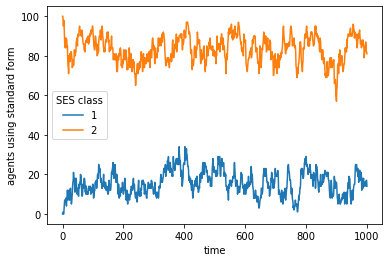

In [223]:
ax = sim_viz.variant_evol(
    evol_variant0, s=s, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)
ax.set_title("")
ax.get_figure().savefig("low_pref_res.pdf")

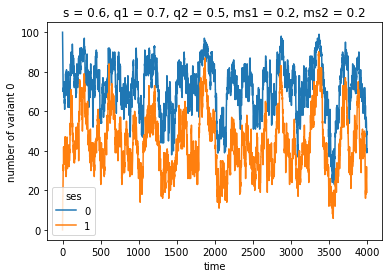

In [41]:
ax = sim_viz.variant_evol(
    evol_variant0, s=s, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

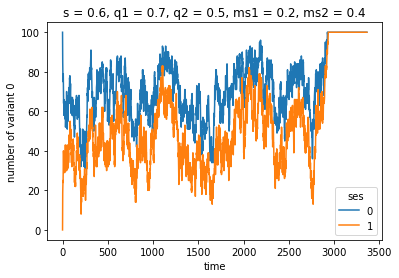

In [32]:
ax = sim_viz.variant_evol(
    evol_variant0, s=s, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

Text(0.5, 1.0, 's = 0.6, q1 = 0.7, q2 = 0.5, ms1=0.5, ms2=0.5')

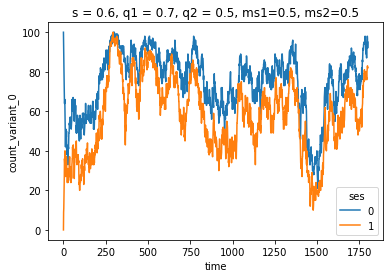

In [271]:
ax = sim_viz.variant_evol(
    evol_variant0, s=s, q1=q1, q2=q2, ms1=prop_moving_in_low_ses, ms2=prop_moving_in_high_ses
)

Text(0.5, 1.0, 's = 0.6, q1 = 0.5, q2 = 0.5, ms1=0.5, ms2=0.5')

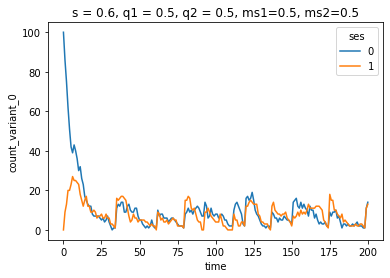

In [230]:
plot_data = (iterations_summary.loc[(slice(None), 0), :]).stack().rename('count_variant_0').reset_index()
ax = sns.lineplot(plot_data, x='time', y='count_variant_0', hue='ses')
ax.set_title(f"s = {s}, q1 = {q1}, q2 = {q2}, ms1={prop_moving_in_low_ses}, ms2={prop_moving_in_high_ses}")

Text(0.5, 1.0, 's = 0.6, q1 = 0.8, q2 = 0.5, ms1=0.5, ms2=0.5')

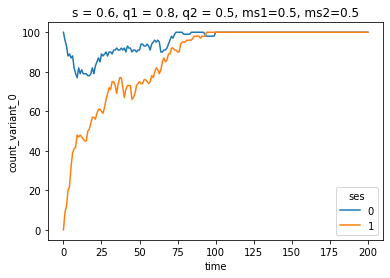

In [224]:
plot_data = (iterations_summary.loc[(slice(None), 0), :]).stack().rename('count_variant_0').reset_index()
ax = sns.lineplot(plot_data, x='time', y='count_variant_0', hue='ses')
ax.set_title(f"s = {s}, q1 = {q1}, q2 = {q2}, ms1={prop_moving_in_low_ses}, ms2={prop_moving_in_high_ses}")